In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot

In [14]:
def ConvertEventToNumpy(dfs, event):
    data = np.zeros(16)
    for i in range(16):
        if i in dfs:
            data[i] = dfs[i].loc[event]["amplitude"]
    data.shape = (4,4)
    return data

In [15]:
def GetAmplitudeSeedPixel(dfs, event):
    maxAmplitude = 0
    maxPixel = -1
    for i in range(16):
        if i in dfs:
            amplitude = dfs[i].loc[event]["amplitude"]
            if amplitude > maxAmplitude:
                maxAmplitude = amplitude
                maxPixel = i
    return maxPixel, maxAmplitude

In [16]:
df = uproot.open("../Data/run175174828_230428174901_preprocessed.root")["PreprocessedData"]
nPixels = 16
dfs = {}

for i in range(nPixels):
    dfs[i] = df[f"pixel{i}"].arrays(library="pd")
dfs

{0:        pixel  samplingPeriod  baseline  minLevel  t10  t90  t50  fallTime  \
 0          0          250000  237.8202  235.7628 -2.0 -2.0 -2.0      -2.0   
 1          0          250000  239.6871  236.3724 -2.0 -2.0 -2.0      -2.0   
 2          0          250000  238.5822  235.6485 -2.0 -2.0 -2.0      -2.0   
 3          0          250000  237.4773  236.6391 -2.0 -2.0 -2.0      -2.0   
 4          0          250000  238.8108  236.4105 -2.0 -2.0 -2.0      -2.0   
 ...      ...             ...       ...       ...  ...  ...  ...       ...   
 47095      0          250000  237.2487  234.5055 -2.0 -2.0 -2.0      -2.0   
 47096      0          250000  236.0295  233.4768 -2.0 -2.0 -2.0      -2.0   
 47097      0          250000  236.2962  234.6960 -2.0 -2.0 -2.0      -2.0   
 47098      0          250000  235.5342  234.3150 -2.0 -2.0 -2.0      -2.0   
 47099      0          250000  236.1057  234.2007 -2.0 -2.0 -2.0      -2.0   
 
        amplitude  electrons       RMS  
 0         2.0574 

<Axes: ylabel='Frequency'>

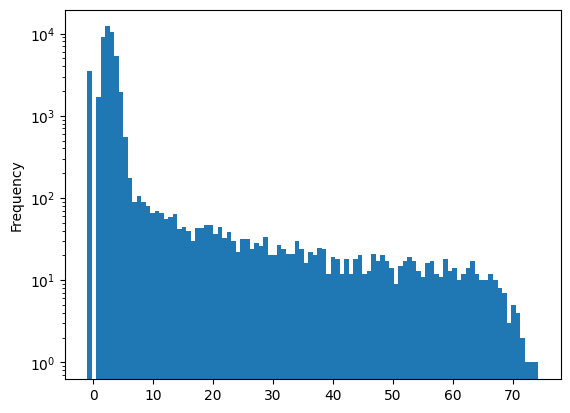

In [17]:
plt.yscale('log')
dfs[1]["amplitude"].plot.hist(bins=100)


In [18]:
dfs[1]["amplitude"]

0        1.7907
1        2.9337
2        1.4097
3        6.4389
4        2.8956
          ...  
47095    4.3053
47096    3.7719
47097    3.3909
47098    3.6576
47099    2.0193
Name: amplitude, Length: 47100, dtype: float64

In [19]:
for i in range(15):
    print(dfs[i].loc[0]["amplitude"])

2.057400023413578
1.7906999947132078
3.9243000487008715
2.552699951240868
3.7338000929884174
-1.0
50.136903981214864
2.438400017706954
2.93370008456111
-1.0
7.441002981858652
3.1241999538050607
2.628900090850749
13.982699960813278
3.8862000796137295


(6, 50.136903981214864)
(9, 24.81872092876925)


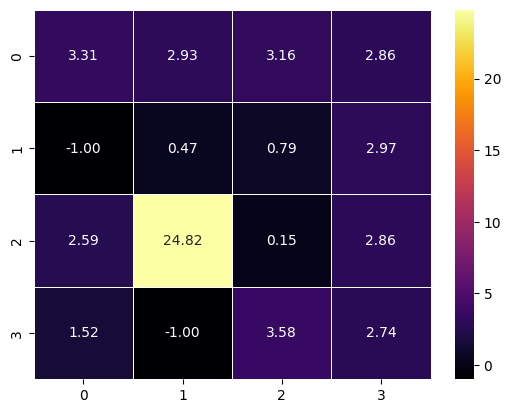

In [20]:
# Create a heatmap of the data
count = 0
for i in range(len(dfs[0])):
    print(GetAmplitudeSeedPixel(dfs, i))
    if GetAmplitudeSeedPixel(dfs, i)[1] > 20:
        if count == 1:
            Event = ConvertEventToNumpy(dfs, i)
            sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno")
            break
        else:
            count += 1

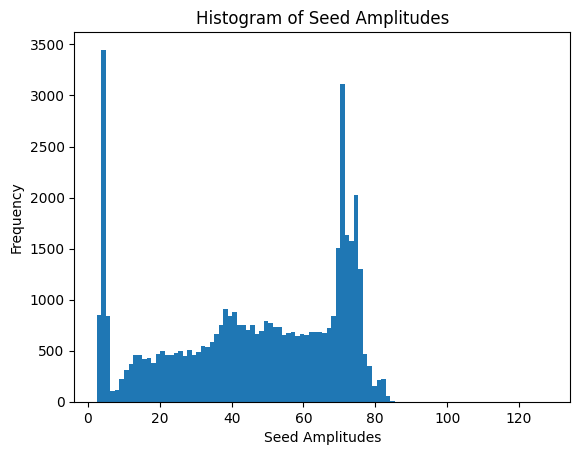

In [21]:
SeedAmplitudes = []
for i in range(len(dfs[0])):
    SeedAmplitudes.append(GetAmplitudeSeedPixel(dfs, i)[1])
plt.hist(SeedAmplitudes, bins=100)
plt.xlabel('Seed Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Seed Amplitudes')
plt.show()


In [22]:
df2 = uproot.open("../Data/run175174828_230428174901_TTree.root")["treeParams"].arrays(library="pd")
df2

/Users/giogi/.pyenv/versions/3.10.8/envs/env1/lib/python3.10/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/Users/giogi/.pyenv/versions/3.10.8/envs/env1/lib/python3.10/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/Users/giogi/.pyenv/versions/3.10.8/envs/env1/lib/python3.10/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  

,Event,Timestamp,BaselinePx0,MinLevelPx0,SignalAmplPx0,t10Px0,t50Px0,t90Px0,FallTimePx0,BaselinePx1,...,t50Px14,t90Px14,FallTimePx14,BaselinePx15,MinLevelPx15,SignalAmplPx15,t10Px15,t50Px15,t90Px15,FallTimePx15
0,0,4096,237.8202,235.7628,2.0574,-999.0,-999.0,-999.0,-999.0,245.6307,...,-999.0,-999.0,-999.0,271.0053,265.4427,5.5626,-999.0,-999.0,-999.0,-999.0
1,1,4096,239.6871,236.3724,3.3147,-999.0,-999.0,-999.0,-999.0,247.6119,...,-999.0,-999.0,-999.0,268.8336,266.0904,2.7432,-999.0,-999.0,-999.0,-999.0
2,2,4096,238.5822,235.6485,2.9337,-999.0,-999.0,-999.0,-999.0,246.1641,...,-999.0,-999.0,-999.0,267.9192,264.8712,3.0480,-999.0,-999.0,-999.0,-999.0
3,3,4096,237.4773,-999.0000,-999.0000,-999.0,-999.0,-999.0,-999.0,247.1166,...,-999.0,-999.0,-999.0,268.3383,266.0904,2.2479,-999.0,-999.0,-999.0,-999.0
4,4,4096,238.8108,236.4105,2.4003,-999.0,-999.0,-999.0,-999.0,246.4308,...,-999.0,-999.0,-999.0,267.7287,265.7856,1.9431,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47096,47096,4096,236.0295,233.4768,2.5527,-999.0,-999.0,-999.0,-999.0,246.4308,...,-999.0,-999.0,-999.0,266.4714,264.1854,2.2860,-999.0,-999.0,-999.0,-999.0
47097,47097,4096,236.2962,234.6960,1.6002,-999.0,-999.0,-999.0,-999.0,245.2878,...,-999.0,-999.0,-999.0,267.3477,264.3378,3.0099,-999.0,-999.0,-999.0,-999.0
47098,47098,4096,235.5342,234.3150,1.2192,-999.0,-999.0,-999.0,-999.0,245.8974,...,-999.0,-999.0,-999.0,266.5095,264.7188,1.7907,-999.0,-999.0,-999.0,-999.0
47099,47099,4096,236.1057,234.2007,1.9050,-999.0,-999.0,-999.0,-999.0,244.5639,...,-999.0,-999.0,-999.0,267.1953,264.3378,2.8575,-999.0,-999.0,-999.0,-999.0


In [28]:
dfs2 = {}
for i in range(nPixels):
    dfs2[i] = df2.filter(like=f'Px{i}').rename(columns = {f"SignalAmpPx{i}": "amplitude"})
    dfs2[i] = dfs2[i].rename(columns = {f"SignalAmplPx{i}": "amplitude"})
dfs2[0]

dfb2 = {}
for i in range(nPixels):
    dfb2[i] = df2.filter(like=f'Px{i}').rename(columns = {f"BaselinePx{i}": "baseline"})
    dfb2[i] = dfb2[i].rename(columns = {f"BaselinePx{i}": "baseline"})
dfb2[0]


,baseline,MinLevelPx0,SignalAmplPx0,t10Px0,t50Px0,t90Px0,FallTimePx0
0,237.8202,235.7628,2.0574,-999.0,-999.0,-999.0,-999.0
1,239.6871,236.3724,3.3147,-999.0,-999.0,-999.0,-999.0
2,238.5822,235.6485,2.9337,-999.0,-999.0,-999.0,-999.0
3,237.4773,-999.0000,-999.0000,-999.0,-999.0,-999.0,-999.0
4,238.8108,236.4105,2.4003,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...
47096,236.0295,233.4768,2.5527,-999.0,-999.0,-999.0,-999.0
47097,236.2962,234.6960,1.6002,-999.0,-999.0,-999.0,-999.0
47098,235.5342,234.3150,1.2192,-999.0,-999.0,-999.0,-999.0
47099,236.1057,234.2007,1.9050,-999.0,-999.0,-999.0,-999.0


In [24]:
dfs[0]

,pixel,samplingPeriod,baseline,minLevel,t10,t90,t50,fallTime,amplitude,electrons,RMS
0,0,250000,237.8202,235.7628,-2.0,-2.0,-2.0,-2.0,2.0574,inf,1.084857
1,0,250000,239.6871,236.3724,-2.0,-2.0,-2.0,-2.0,3.3147,inf,0.946819
2,0,250000,238.5822,235.6485,-2.0,-2.0,-2.0,-2.0,2.9337,inf,0.964622
3,0,250000,237.4773,236.6391,-2.0,-2.0,-2.0,-2.0,-1.0000,-inf,0.775861
4,0,250000,238.8108,236.4105,-2.0,-2.0,-2.0,-2.0,2.4003,inf,0.924585
...,...,...,...,...,...,...,...,...,...,...,...
47095,0,250000,237.2487,234.5055,-2.0,-2.0,-2.0,-2.0,2.7432,inf,1.070298
47096,0,250000,236.0295,233.4768,-2.0,-2.0,-2.0,-2.0,2.5527,inf,1.451007
47097,0,250000,236.2962,234.6960,-2.0,-2.0,-2.0,-2.0,1.6002,inf,1.046911
47098,0,250000,235.5342,234.3150,-2.0,-2.0,-2.0,-2.0,1.2192,inf,0.994492


(6, 23.17448331461005)
(9, 11.186289252352374)
(6, 32.08557266784481)


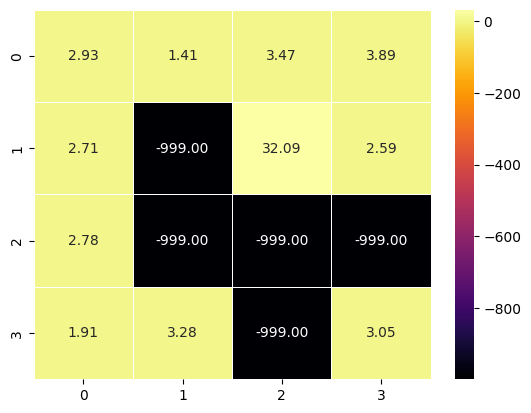

In [25]:
# Create a heatmap of the data
count = 0
for i in range(len(dfs2[0])):
    print(GetAmplitudeSeedPixel(dfs2, i))
    if GetAmplitudeSeedPixel(dfs2, i)[1] > 20:
        if count == 1:
            Event = ConvertEventToNumpy(dfs2, i)
            sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno")
            break
        else:
            count += 1

<Axes: >

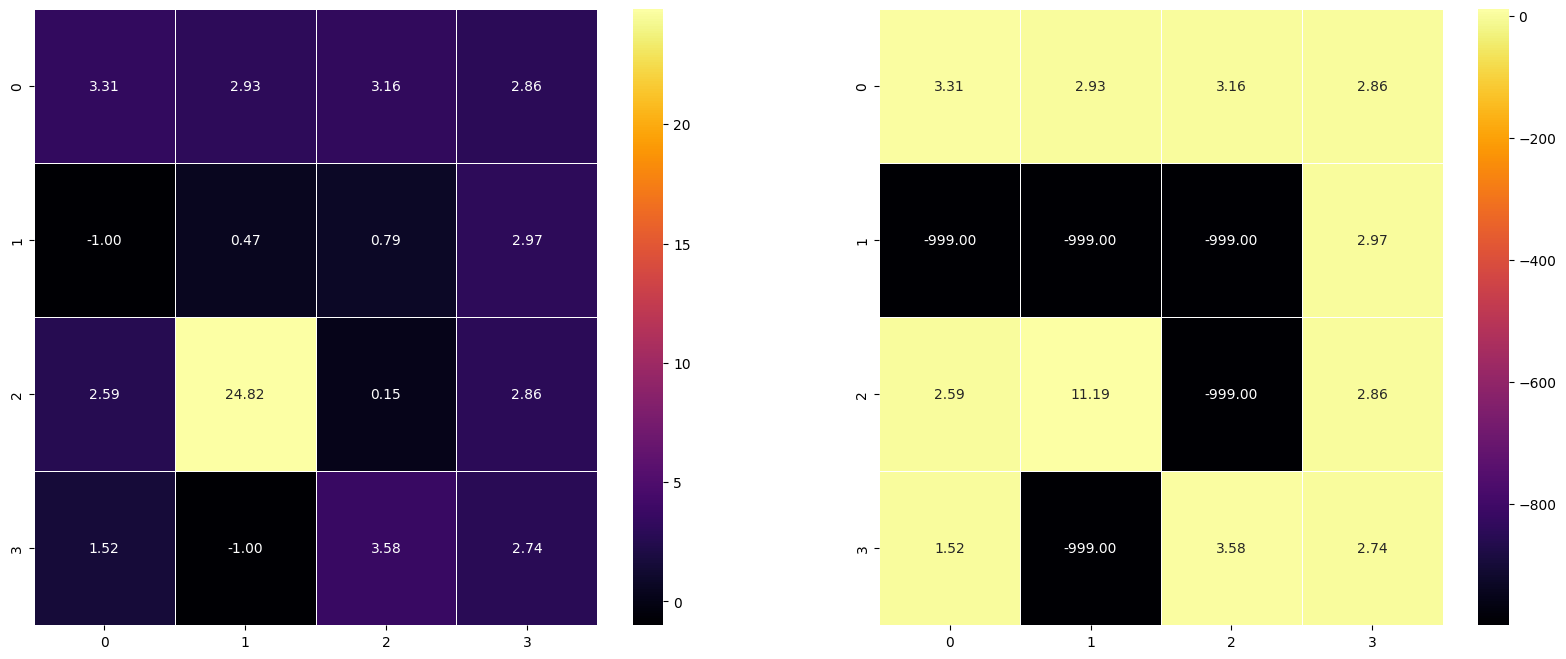

In [32]:
fig, axs = plt.subplots(1,2, figsize=(20,8))
EvN = 1
Event = ConvertEventToNumpy(dfs, EvN)
sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno", ax=axs[0])
Event = ConvertEventToNumpy(dfs2, EvN)
sns.heatmap(Event, annot=True, fmt=".2f", linewidths=.5, cmap="inferno", ax=axs[1])

In [34]:
print("Gruppo 1")
for i in range(16): print(dfs[i].loc[0]["baseline"])
print("Prino/Aglietta")
for i in range(16): print(dfb2[i].loc[0]["baseline"])


Gruppo 1
237.82020002341358
245.6306999947132
237.43920004870088
253.4411999512409
238.08690009298843
50.80900112170039
49.136903990219444
222.77070001770696
226.39020008456112
47.95466738134127
50.33720261006903
239.72519995380506
218.38920009085075
248.37389996081328
244.18290007961374
271.0052999833302
Prino/Aglietta
237.82020002341358
245.6306999947132
237.43920004870088
253.4411999512409
238.08690009298843
50.611716567692284
21.999815292649554
222.77070001770696
226.39020008456112
47.77156546019673
46.18543088016418
239.72519995380506
218.38920009085075
248.37389996081328
244.18290007961374
271.0052999833302
